Copyright 2020 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Assess privacy risks with TensorFlow Privacy Membership Inference Attacks

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/privacy_tests/membership_inference_attack/codelabs/codelab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/privacy_tests/membership_inference_attack/codelabs/codelab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

##Overview
In this codelab we'll train a simple image classification model on the CIFAR10 dataset, and then use the "membership inference attack" against this model to assess if the attacker is able to "guess" whether a particular sample was present in the training set.

## Setup
First, set this notebook's runtime to use a GPU, under Runtime > Change runtime type > Hardware accelerator. Then, begin importing the necessary libraries.

In [ ]:
#@title Import statements.
import numpy as np
from typing import Tuple, Text
from scipy import special

import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds

# Set verbosity.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter(action="ignore", category=ConvergenceWarning)
simplefilter(action="ignore", category=FutureWarning)

### Install TensorFlow Privacy.

In [ ]:
!pip3 install git+https://github.com/tensorflow/privacy

from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/privacy to /tmp/pip-req-build-5f3qghz4
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/privacy /tmp/pip-req-build-5f3qghz4
  Resolved https://github.com/tensorflow/privacy to commit a3e8a45559bade7841d4454cee267adf5894ea09
  Preparing metadata (setup.py) ... done


## Train a model

In [ ]:
cifar100 = tf.keras.datasets.cifar100
  
# Distribute it to train and test set
(x_train, y_train), (x_val, y_val) = cifar100.load_data()
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [ ]:
import matplotlib.pyplot as plt


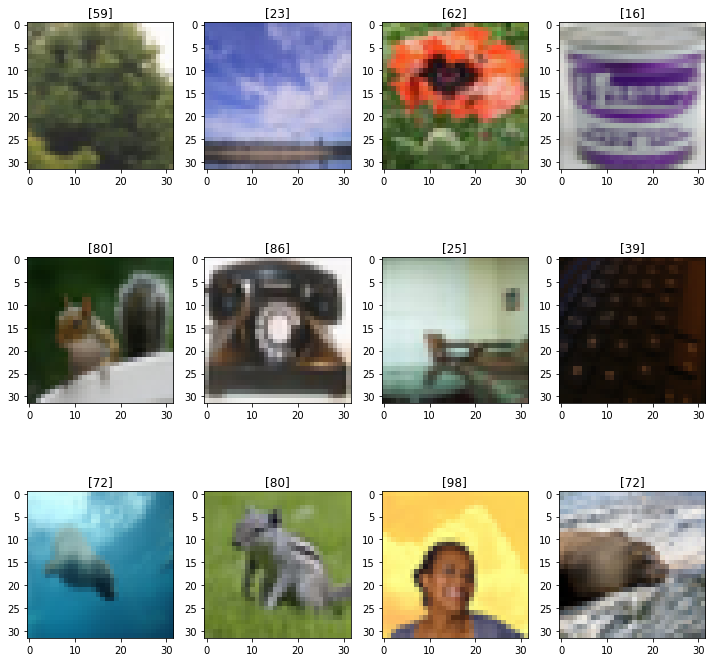

In [ ]:
def show_samples(data, labels):
    plt.subplots(figsize=(10, 10))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        k = np.random.randint(0, data.shape[0])
        plt.title(labels[k])
        plt.imshow(data[k])
    plt.tight_layout()
    plt.show()
  
  
show_samples(x_train, y_train)

In [ ]:
y_train = tf.one_hot(y_train,
                     depth=y_train.max() + 1,
                     dtype=tf.float64)
y_val = tf.one_hot(y_val,
                   depth=y_val.max() + 1,
                   dtype=tf.float64)
  
y_train = tf.squeeze(y_train)
y_val = tf.squeeze(y_val)

In [ ]:
# print(y_train)
# print(type(y_train))

In [ ]:
model = tf.keras.models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu',
                  input_shape=(32, 32, 3), padding='same'),
    layers.Conv2D(32, (3, 3),
                  activation='relu',
                  padding='same'),
    layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same'),
  
  
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(100, activation='softmax')
])
  
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['AUC', 'accuracy']
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                      

In [ ]:
hist = model.fit(x_train, y_train,
                 epochs=5,
                 batch_size=64,
                 verbose=1,
                 validation_data=(x_val, y_val))

Epoch 1/5


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


782/782 [==============================] - 25s 16ms/step - loss: 3.9561 - auc: 0.7775 - accuracy: 0.1068 - val_loss: 3.5545 - val_auc: 0.8349 - val_accuracy: 0.1728
Epoch 2/5
782/782 [==============================] - 10s 13ms/step - loss: 3.2583 - auc: 0.8707 - accuracy: 0.2094 - val_loss: 3.0910 - val_auc: 0.8894 - val_accuracy: 0.2449
Epoch 3/5
782/782 [==============================] - 10s 13ms/step - loss: 2.8276 - auc: 0.9079 - accuracy: 0.2893 - val_loss: 2.6111 - val_auc: 0.9215 - val_accuracy: 0.3447
Epoch 4/5
782/782 [==============================] - 10s 13ms/step - loss: 2.4390 - auc: 0.9322 - accuracy: 0.3680 - val_loss: 2.5638 - val_auc: 0.9231 - val_accuracy: 0.3715
Epoch 5/5
782/782 [==============================] - 10s 12ms/step - loss: 2.1227 - auc: 0.9485 - accuracy: 0.4333 - val_loss: 2.5360 - val_auc: 0.9155 - val_accuracy: 0.3652


## Calculate logits, probabilities and loss values for training and test sets.

We will use these values later in the membership inference attack to separate training and test samples.

In [ ]:
print('Predict on train...')
logits_train = model.predict(x_train, batch_size=64)
print('Predict on test...')
logits_test = model.predict(x_val, batch_size=64)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

loss_train = cce(constant(y_train.numpy()), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_val.numpy()), constant(prob_test), from_logits=False).numpy()

Predict on train...
782/782 [==============================] - 3s 3ms/step
Predict on test...
157/157 [==============================] - 1s 3ms/step
Apply softmax to get probabilities from logits...
Compute losses...


## Run membership inference attacks.

We will now execute a membership inference attack against the previously trained CIFAR10 model. This will generate a number of scores, most notably, attacker advantage and AUC for the membership inference classifier.

An AUC of close to 0.5 means that the attack wasn't able to identify training samples, which means that the model doesn't have privacy issues according to this test. Higher values, on the contrary, indicate potential privacy issues.

Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an AUC of 0.72 on slice CLASS=98
  LOGISTIC_REGRESSION (with 500 training and 100 test examples) achieved an advantage of 0.37 on slice CLASS=28
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved a positive predictive value of 1.00 on slice CLASS=1

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 50000 training and 10000 test examples) achieved an AUC of 0.61
  LOGISTIC_REGRESSION (with 50000 training and 10000 test examples) achieved an advantage of 0.29
  LOGISTIC_REGRESSION (with 50000 training and 10000 test examples) achieved a positive predictive value of 0.98

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 500 training and 100 test examples) achieved an AUC of 0.56
  LOGISTIC_REGRESSION (with 500 training and 100 test examples) achieved an advantage of 0.19
  LOGISTIC_REGRESSION (with 500 trai

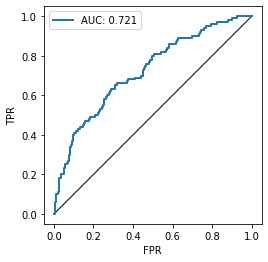

In [ ]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting

labels_train = np.argmax(y_train, axis=1)
labels_test = np.argmax(y_val, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                 SlicingSpec(
                                     entire_dataset = True,
                                     by_class = True,
                                     by_classification_correctness = True
                                 ),
                                 attack_types = [
                                     AttackType.THRESHOLD_ATTACK,
                                     AttackType.LOGISTIC_REGRESSION])

# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

# Print a user-friendly summary of the attacks
print(attacks_result.summary(by_slices = True))

This is the end of the codelab!
Feel free to change the parameters to see how the privacy risks change.

You can try playing with:
* the number of training epochs
* different attack_types